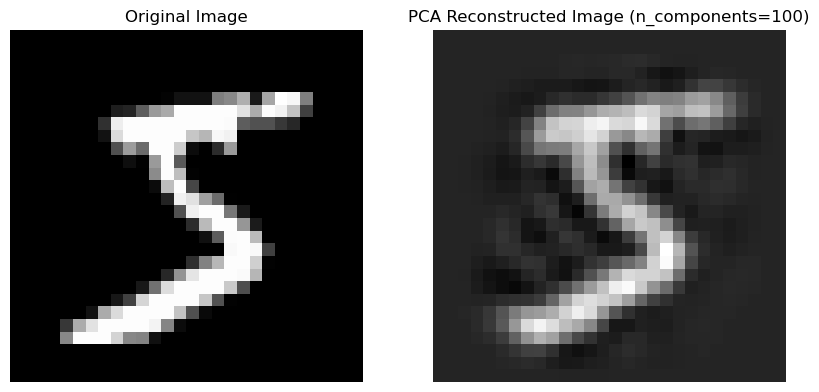

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test
from federated_learning import distribute_global_model, federated_averaging

# Initialization

In [6]:
# Predefined stuff

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [10]:
print((train_loader.dataset))

Dataset MNIST
    Number of datapoints: 60000
    Root location: /files/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [12]:
# get their respective data

train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [14]:
# PCA DR, later encapsulate this shit
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 


train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.1307) / 0.3081

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)


In [16]:
trainingset_pca = train_loader_reduced_pca.dataset

print(trainingset_pca.targets)

tensor([4, 8, 8,  ..., 7, 0, 8])


In [18]:
# Autoencoder initialization, does take time because the Autoencoder has to be trained first. Later maybe store the parameters.
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")


Epoch [1/5], Loss: 0.5411480665206909
Epoch [2/5], Loss: 0.5199205279350281
Epoch [3/5], Loss: 0.4910971224308014
Epoch [4/5], Loss: 0.519383430480957
Epoch [5/5], Loss: 0.5129168033599854


In [22]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)


In [24]:
# Experiment for multiple alphas
alpha_values = [0.005, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
results = {"classic": {}, "pca": {}, "autoencoder": {}}

for alpha in alpha_values:
    print(f"\nRunning experiment for alpha = {alpha}\n")

    # Partition datasets for each method
    partitioned_data_classic = partition.balanced_dirichlet_partition(
        train_loader.dataset, partitions_number=4, alpha=alpha)
    classic_client_loaders = [
        DataLoader(Subset(train_loader.dataset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]

    partitioned_data_pca = partition.balanced_dirichlet_partition(
        train_loader_reduced_pca.dataset, partitions_number=4, alpha=alpha)
    pca_client_loaders = [
        DataLoader(Subset(train_loader_reduced_pca.dataset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    partitioned_data_auto = partition.balanced_dirichlet_partition(
        reduced_train_loader_auto.dataset, partitions_number=4, alpha=alpha)
    auto_client_loaders = [
        DataLoader(Subset(reduced_train_loader_auto.dataset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    if (alpha == 0.005) : 
        for i in range(len(pca_client_loaders[0].dataset)):
            sample, label = pca_client_loaders[0].dataset[i]
            print(f"Sample {i} shape: {sample.shape}, Label: {label}")
    

    # Federated learning for classic
    gloabl_model_classic = classification_model()
    local_models_classic = [copy.deepcopy(gloabl_model_classic) for _ in range(4)]
    test_losses_classic, test_accuracies_classic = [], []
    for round_idx in range(4):
        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic):
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, [], [])
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
        global_weights_classic = federated_averaging(local_weights_classic)
        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, gloabl_model_classic, single=True)
    test(gloabl_model_classic, test_loader, test_losses_classic)
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = gloabl_model_classic(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    results["classic"][alpha] = {"losses": test_losses_classic, "accuracy": test_accuracies_classic}

    # Federated learning for PCA
    global_model_pca = classification_model()
    local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(4)]
    test_losses_pca, test_accuracies_pca = [], []
    for round_idx in range(4):
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca):
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, [], [])
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
        global_weights_pca = federated_averaging(local_weights_pca)
        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)
    test(global_model_pca, test_loader_pca, test_losses_pca)
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_pca:
            output = global_model_pca(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    results["pca"][alpha] = {"losses": test_losses_pca, "accuracy": test_accuracies_pca}

    # Federated learning for Autoencoder
    global_model_auto = classification_model()
    local_models_auto = [copy.deepcopy(global_model_auto) for _ in range(4)]
    test_losses_auto, test_accuracies_auto = [], []
    for round_idx in range(4):
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_models_auto):
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, [], [])
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        global_weights_auto = federated_averaging(local_weights_auto)
        distribute_global_model(global_weights_auto, local_models_auto, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)
    test(global_model_auto, test_loader_auto, test_losses_auto)
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_auto:
            output = global_model_auto(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_auto.dataset)
    test_accuracies_auto.append(accuracy)
    results["autoencoder"][alpha] = {"losses": test_losses_auto, "accuracy": test_accuracies_auto}



Running experiment for alpha = 0.005

Sample 0 shape: torch.Size([1, 28, 28]), Label: 9
Sample 1 shape: torch.Size([1, 28, 28]), Label: 2
Sample 2 shape: torch.Size([1, 28, 28]), Label: 7
Sample 3 shape: torch.Size([1, 28, 28]), Label: 1
Sample 4 shape: torch.Size([1, 28, 28]), Label: 2
Sample 5 shape: torch.Size([1, 28, 28]), Label: 9
Sample 6 shape: torch.Size([1, 28, 28]), Label: 9
Sample 7 shape: torch.Size([1, 28, 28]), Label: 9
Sample 8 shape: torch.Size([1, 28, 28]), Label: 7
Sample 9 shape: torch.Size([1, 28, 28]), Label: 1
Sample 10 shape: torch.Size([1, 28, 28]), Label: 1
Sample 11 shape: torch.Size([1, 28, 28]), Label: 2
Sample 12 shape: torch.Size([1, 28, 28]), Label: 9
Sample 13 shape: torch.Size([1, 28, 28]), Label: 2
Sample 14 shape: torch.Size([1, 28, 28]), Label: 9
Sample 15 shape: torch.Size([1, 28, 28]), Label: 9
Sample 16 shape: torch.Size([1, 28, 28]), Label: 1
Sample 17 shape: torch.Size([1, 28, 28]), Label: 2
Sample 18 shape: torch.Size([1, 28, 28]), Label: 9
Sa

C:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/21041 (0%)]	Loss: 2.258013
Train Epoch: 1 [640/21041 (3%)]	Loss: 1.918931
Train Epoch: 1 [1280/21041 (6%)]	Loss: 1.684778
Train Epoch: 1 [1920/21041 (9%)]	Loss: 1.436636
Train Epoch: 1 [2560/21041 (12%)]	Loss: 1.211163
Train Epoch: 1 [3200/21041 (15%)]	Loss: 0.963127
Train Epoch: 1 [3840/21041 (18%)]	Loss: 0.748880
Train Epoch: 1 [4480/21041 (21%)]	Loss: 0.699386
Train Epoch: 1 [5120/21041 (24%)]	Loss: 0.910122
Train Epoch: 1 [5760/21041 (27%)]	Loss: 0.657501
Train Epoch: 1 [6400/21041 (30%)]	Loss: 0.560597
Train Epoch: 1 [7040/21041 (33%)]	Loss: 0.486378
Train Epoch: 1 [7680/21041 (36%)]	Loss: 0.599003
Train Epoch: 1 [8320/21041 (40%)]	Loss: 0.401372
Train Epoch: 1 [8960/21041 (43%)]	Loss: 0.353548
Train Epoch: 1 [9600/21041 (46%)]	Loss: 0.548912
Train Epoch: 1 [10240/21041 (49%)]	Loss: 0.471751
Train Epoch: 1 [10880/21041 (52%)]	Loss: 0.615155
Train Epoch: 1 [11520/21041 (55%)]	Loss: 0.425760
Train Epoch: 1 [12160/21041 (58%)]	Loss: 0.343108
Train Epoch: 1 [12800/21

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4994, Accuracy: 8472/10000 (85%)

Train Epoch: 1 [0/21041 (0%)]	Loss: 2.518738
Train Epoch: 1 [640/21041 (3%)]	Loss: 1.542445
Train Epoch: 1 [1280/21041 (6%)]	Loss: 1.288543
Train Epoch: 1 [1920/21041 (9%)]	Loss: 0.734254
Train Epoch: 1 [2560/21041 (12%)]	Loss: 0.638306
Train Epoch: 1 [3200/21041 (15%)]	Loss: 0.710419
Train Epoch: 1 [3840/21041 (18%)]	Loss: 0.421379
Train Epoch: 1 [4480/21041 (21%)]	Loss: 0.711052
Train Epoch: 1 [5120/21041 (24%)]	Loss: 0.577776
Train Epoch: 1 [5760/21041 (27%)]	Loss: 0.559083
Train Epoch: 1 [6400/21041 (30%)]	Loss: 0.444563
Train Epoch: 1 [7040/21041 (33%)]	Loss: 0.596128
Train Epoch: 1 [7680/21041 (36%)]	Loss: 0.327657
Train Epoch: 1 [8320/21041 (40%)]	Loss: 0.322563
Train Epoch: 1 [8960/21041 (43%)]	Loss: 0.514381
Train Epoch: 1 [9600/21041 (46%)]	Loss: 0.402027
Train Epoch: 1 [10240/21041 (49%)]	Loss: 0.312196
Train Epoch: 1 [10880/21041 (52%)]	Loss: 0.394931
Train Epoch: 1 [11520/21041 (55%)]	Loss: 0.253491
Train Epoch: 1 [

In [ ]:
#Todo??
testSetAvgLosses = [1.0049, 0.6043, 0.3336, 0.8381, 0.7255, ....]
testSetAvgAccuracy = [92, 83, 90, 91, 81, ....]

In [26]:
for method, method_results in results.items():
    print(f"\nResults for {method}:")
    for alpha, metrics in method_results.items():
        print(f"  Alpha {alpha}: Losses = {metrics['losses']}, Accuracy = {metrics['accuracy']}")


Results for classic:
  Alpha 0.005: Losses = [0.49943628845214844], Accuracy = [84.72]
  Alpha 0.05: Losses = [0.3336496337890625], Accuracy = [89.66]
  Alpha 0.1: Losses = [0.16874794006347657], Accuracy = [94.83]
  Alpha 0.3: Losses = [0.14123596801757812], Accuracy = [96.0]
  Alpha 0.5: Losses = [0.11874948120117187], Accuracy = [96.15]
  Alpha 0.7: Losses = [0.10253834075927734], Accuracy = [96.56]
  Alpha 0.9: Losses = [0.10070584869384766], Accuracy = [97.05]
  Alpha 1: Losses = [0.09446857681274413], Accuracy = [96.94]

Results for pca:
  Alpha 0.005: Losses = [1.0049324462890625], Accuracy = [92.18]
  Alpha 0.05: Losses = [0.8381243835449219], Accuracy = [91.32]
  Alpha 0.1: Losses = [0.6158310668945313], Accuracy = [95.93]
  Alpha 0.3: Losses = [0.4067485534667969], Accuracy = [97.47]
  Alpha 0.5: Losses = [0.4018714111328125], Accuracy = [97.05]
  Alpha 0.7: Losses = [0.37564517517089846], Accuracy = [97.7]
  Alpha 0.9: Losses = [0.3578442749023438], Accuracy = [97.49]
  Alp

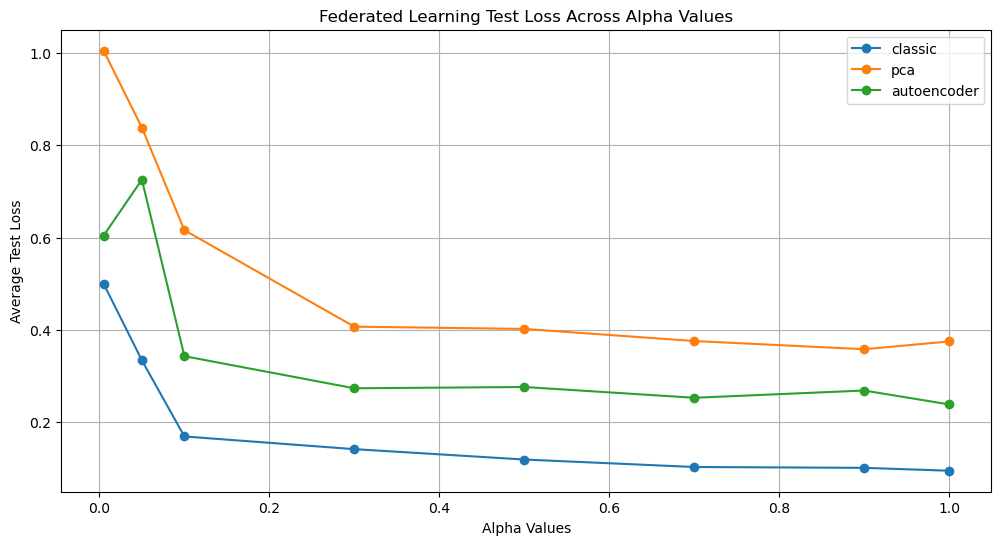

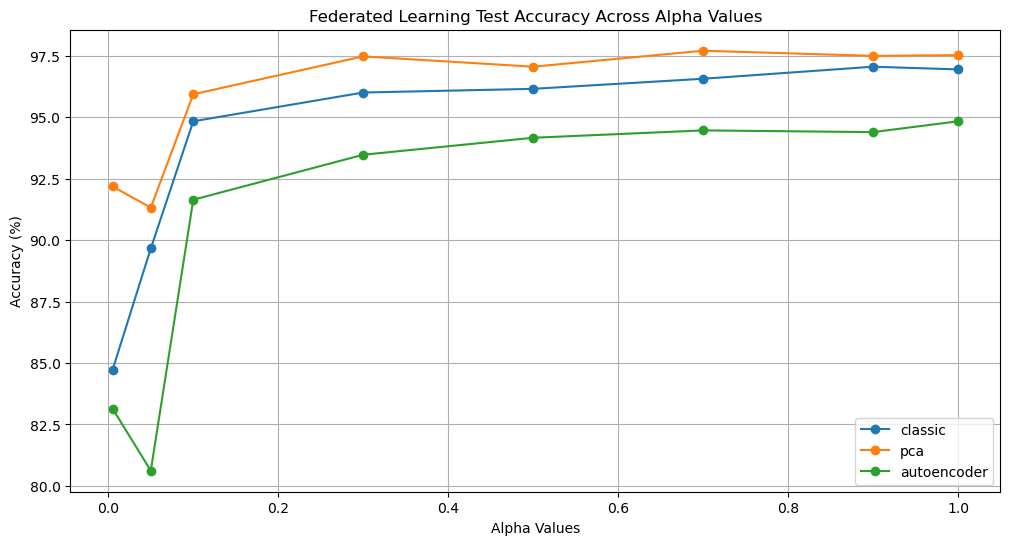

In [38]:
import matplotlib.pyplot as plt

alpha_values = list(results["classic"].keys())
methods = list(results.keys())
losses = {method: [results[method][alpha]["losses"] for alpha in alpha_values] for method in methods}
accuracies = {method: [results[method][alpha]["accuracy"] for alpha in alpha_values] for method in methods}

plt.figure(figsize=(12, 6))
for method in methods:
    avg_losses = [sum(loss) / len(loss) for loss in losses[method]]  
    #print(avg_losses)
    plt.plot(alpha_values, avg_losses, marker='o', label=method)

plt.xlabel('Alpha Values')
plt.ylabel('Average Test Loss')
plt.title('Federated Learning Test Loss Across Alpha Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for method in methods:
    avg_accuracies = [sum(acc) / len(acc) for acc in accuracies[method]]  
    #print(avg_accuracies)
    plt.plot(alpha_values, avg_accuracies, marker='o', label=method)
plt.xlabel('Alpha Values')
plt.ylabel('Accuracy (%)')
plt.title('Federated Learning Test Accuracy Across Alpha Values')
plt.legend()
plt.grid(True)
plt.show()
